# Deploy a TSFM Inference Endpoint on Amazon Sagemaker


In this notebook, we walk through the process of deploying an IBM granite timeseries inference service enpoint on Amazon SageMaker. This notebook will recreate the steps taken in [this tsfm-granite recipe](https://github.com/ibm-granite-community/granite-timeseries-cookbook/blob/main/recipes/Time_Series/Time_Series_Getting_Started.ipynb) with the only difference being that the deployment and inference will be on AWS Sagemaker.

In [1]:
# obtain tsfm requirements
import shutil
import subprocess
from pathlib import Path


# so that some code directories from the granite-tsfm repo can be added to the sys.path
shutil.rmtree("code/granite-tsfm", ignore_errors=True)
assert not Path("code/granite-tsfm").exists()
subprocess.run(
    check=True,
    stdout=subprocess.DEVNULL,
    cwd="code",
    args=[
        "git",
        "clone",
        "-b",
        "sagemaker",
        "--depth",
        "1",
        "https://github.com/ibm-granite/granite-tsfm.git",
    ],
)
shutil.copy("code/granite-tsfm/services/inference/requirements.txt", "code")
# set up tsfm services layer
# 1. boilerplate code
subprocess.run(
    check=True, stdout=subprocess.DEVNULL, cwd="code/granite-tsfm/services/inference", args=["make", "boilerplate"]
)
# 2. tsfm-granite public models
# you must have git-lfs installed for this
subprocess.run(check=True, stdout=subprocess.DEVNULL, args=["git-lfs"])
subprocess.run(
    check=True, stdout=subprocess.DEVNULL, cwd="code/granite-tsfm/services/inference", args=["make", "clone_models"]
)

Cloning into 'granite-tsfm'...
Cloning into 'mytest-tsfm'...
Filtering content: 100% (15/15), 104.18 MiB | 23.12 MiB/s, done.


CompletedProcess(args=['make', 'clone_models'], returncode=0)

In [2]:
# obtain the mdhash of our repo so that models and endpoints can use that in their name
result = subprocess.run(
    cwd="code/granite-tsfm/services/inference",
    args=["git", "rev-parse", "--short", "HEAD"],
    capture_output=True,
    text=True,
)
tsfm_release = f"tsfm-public-{result.stdout.strip()}"

result = subprocess.run(
    cwd="code/granite-tsfm/services/inference/mytest-tsfm",
    args=["git", "rev-parse", "--short", "HEAD"],
    capture_output=True,
    text=True,
)
tsfm_model_release = f"model-release-{result.stdout.strip()}"
identifier = f"{tsfm_release}-{tsfm_model_release}"
identifier

'tsfm-public-50d698e-model-release-fc98672'

In [3]:
# upload our code and model artifacts to our default S3 bucket

import subprocess

import boto3
from sagemaker import Session
from sagemaker.pytorch import PyTorchModel


# Make sure you have run the aws cli command "aws config" to set up your system correctly
# with your aws credentials

boto3_session = boto3.Session()

sess = Session(boto_session=boto3_session)
role = "arn:aws:iam::481118440516:role/SagemakerFullAccessRole"

# create the tarball of code and model artifacts
subprocess.run(
    check=True,
    stdout=subprocess.DEVNULL,
    args=[
        "tar",
        "--exclude",
        "*.git/**",
        "-czvf",
        "model.tar.gz",
        "code/inference.py",
        "code/requirements.txt",
        "code/granite-tsfm/services/inference",
    ],
)

# upload the tarball to our default s3 bucket so that sagemaker can see it
tsfm_tarball = sess.upload_data(path="model.tar.gz", bucket=sess.default_bucket(), key_prefix="model/pytorch")

/home/stus/py311/lib64/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/06/25 21:25:20] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=946571;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=185883;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/stus/.config/sagemaker/config.yaml


[01/06/25 21:25:21] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=569402;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=797770;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py#1278\1278]8;;\

## PyTorch Model Object

The `PyTorchModel` class allows you to define an environment for making inference using your
model artifact. Like the `PyTorch` class discussed 
[in this notebook for training an PyTorch model](get_started_mnist_train.ipynb), it is a high level API used to set up a docker image for your model hosting service.

Once it is properly configured, it can be used to create a SageMaker
endpoint on an EC2 instance. The SageMaker endpoint is a containerized environment that uses your trained model 
to make inference on incoming data via RESTful API calls. 

Some common parameters used to initiate the `PyTorchModel` class are:
- `entry_point`: A user defined python file to be used by the inference image as handlers of incoming requests
- `source_dir`: The directory of the `entry_point`
- `role`: An IAM role to make AWS service requests
- `model_data`: the S3 location of the compressed model artifact. It can be a path to a local file if the endpoint 
is to be deployed on the SageMaker instance you are using to run this notebook (local mode)
- `framework_version`: version of the PyTorch package to be used
- `py_version`: python version to be used

In [4]:
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    role=role,
    model_data=tsfm_tarball,
    framework_version="2.5",
    py_version="py311",
    name=f"model-{identifier}",
)

## Deploy the inference container
Once the `PyTorchModel` class is initiated, we can call its `deploy` method to run the container for the hosting
service. Some common parameters needed to call `deploy` methods are:

- `initial_instance_count`: the number of SageMaker instances to be used to run the hosting service.
- `instance_type`: the type of SageMaker instance to run the hosting service. Set it to `local` if you want to run the hosting service on the local SageMaker instance. Local mode is typically used for debugging. 
- `serializer`: A python callable used to serialize (encode) the request data.
- `deserializer`: A python callable used to deserialize (decode) the response data.

Commonly used serializers and deserializers are implemented in `sagemaker.serializers` and `sagemaker.deserializers`
submodules of the SageMaker Python SDK. 

Since in the `transform_fn` we declared that the incoming requests are json-encoded, we need to use a `json serializer`,
to encode the incoming data into a json string.

In [5]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer


instance_type = "ml.c4.xlarge"

# this could take up to five minutes to complete
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    endpoint_name=f"endpoint-{identifier}",
)
predictor

[01/06/25 21:25:39] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=418583;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=534074;file:///home/stus/py311/lib64/python3.11/site-packages/botocore/credentials.py#1278\1278]8;;\

[01/06/25 21:25:40] INFO     Repacking model artifact                                                  ]8;id=838480;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=975938;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-2-481118440516/model/pytorch/model.tar.gz),                   
                             script artifact (code), and dependencies ([]) into single tar.gz file                 
                             located at                                                                            
                             s3://sagemaker-us-east-2-481118440516/model-tsfm-public-50d698e-model-rel             
                             ease-fc98672/model.tar.gz. This may take some time depending on model                 
                             size...                                                                               

[01/06/25 21:26:00] INFO     Creating model with name:                                              ]8;id=401763;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=638680;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\
                             model-tsfm-public-50d698e-model-release-fc98672                                       

[01/06/25 21:26:01] INFO     Creating endpoint-config with name                                     ]8;id=69222;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=559345;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             endpoint-tsfm-public-50d698e-model-release-fc98672                                    

                    INFO     Creating endpoint with name                                            ]8;id=77722;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=100426;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\
                             endpoint-tsfm-public-50d698e-model-release-fc98672                                    

-------!

The `predictor` we get above can be used to make prediction requests against a SageMaker endpoint. 
For more information, check [the API reference for SageMaker Predictor](
https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.predictor)

Now, let's test the endpoint with electricity ususage data.

## Read the data

We parse the csv into a pandas dataframe, filling in any null values, and create a single window containing context_length time points. We ensure the timestamp column is a datetime.

In [6]:
from datetime import datetime

import pandas as pd


timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512


# Read in the data from the downloaded file.
input_df = pd.read_csv(
    "hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv",
    parse_dates=[timestamp_column],  # Parse the timestamp values as dates.
)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

/home/stus/py311/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


## Plot the target series

Here we inspect a preview of the target time series column.


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


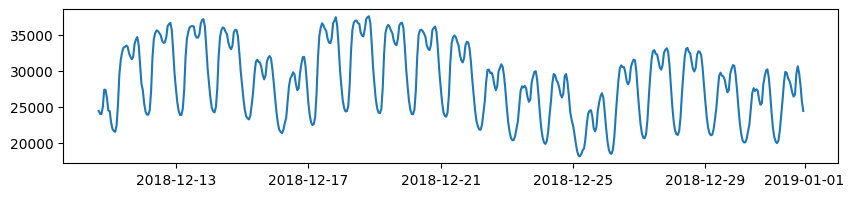

In [7]:
! pip install -q matplotlib
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

Prepare the payload

In [8]:
# since we'll be making a REST call, we need to covert the time column to string type
# so that it's json serializable
import copy


original_input_df = copy.deepcopy(input_df)

input_df[timestamp_column] = input_df[timestamp_column].apply(lambda x: x.isoformat())

payload = {
    "inference_type": "forecasting",  # we currently support only 'forecasting'
    "model_id": "ttm-r2",
    "parameters": {},
    "schema": {
        "timestamp_column": timestamp_column,
        "id_columns": [],  # single timeseries doesn't reqiure id_columns
        "target_columns": target_columns,  # what we're generating a forecast for
    },
    "data": input_df.to_dict(orient="list"),
    "future_data": {},  # used for things like exogenous data
}

Use the predictor to generate a forecast

In [9]:
# import json
res = predictor.predict(payload)

In [10]:
# convert back to a pandas dataframe
# note that [0] are the predictions for the first--and in this case only--timeseries "A"
results_df = pd.DataFrame.from_dict(res["results"][0])
# so that we can plot correctly
results_df[timestamp_column] = results_df[timestamp_column].apply(lambda x: datetime.fromisoformat(x))
# the first 10 predictions
results_df.tail()

,time,total load actual
91,2019-01-04 19:00:00+01:00,31369.992188
92,2019-01-04 20:00:00+01:00,31666.273438
93,2019-01-04 21:00:00+01:00,31094.183594
94,2019-01-04 22:00:00+01:00,29409.898438
95,2019-01-04 23:00:00+01:00,27393.582031


## Plot the predicted values on the same axis as the ground truth values

This gives a good sense of how well the model caputure the trends in the data

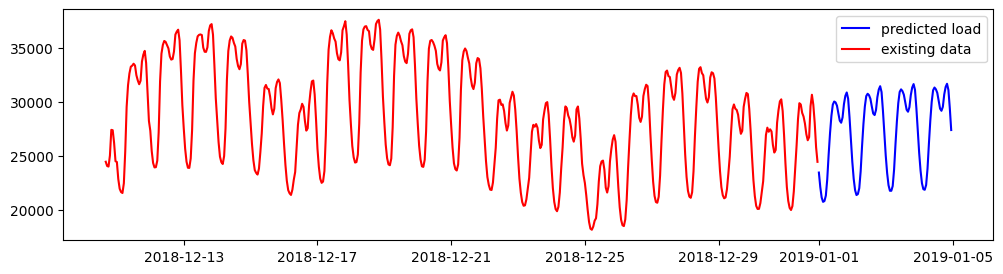

In [20]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(12, 3 * len(target_columns)), squeeze=False)

for ax, target_column in zip(axs, target_columns):
    ax[0].plot(results_df[timestamp_column], results_df[target_column], label="predicted load", color="blue")
    ax[0].plot(original_input_df[timestamp_column], original_input_df[target_column], label="existing data", color="red")
    ax[0].legend()


## (Optional) Clean up 

If you do not plan to use the endpoint, you should delete it to free up some computation 
resource. If you use local, you will need to manually delete the docker container bounded
at port 8080 (the port that listens to the incoming request).


In [13]:
predictor.delete_model()
predictor.delete_endpoint()

[01/06/25 21:31:07] INFO     Deleting model with name:                                              ]8;id=675384;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=403669;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#5226\5226]8;;\
                             model-tsfm-public-50d698e-model-release-fc98672                                       

                    INFO     Deleting endpoint configuration with name:                             ]8;id=266575;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=993170;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             endpoint-tsfm-public-50d698e-model-release-fc98672                                    

                    INFO     Deleting endpoint with name:                                           ]8;id=641430;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=209955;file:///home/stus/py311/lib64/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\
                             endpoint-tsfm-public-50d698e-model-release-fc98672                                    